# Notebook: Evaluation

In [31]:
%load_ext autoreload
%autoreload 2
import random
from cap.dehaze import dehaze as cap_dehaze_img
from dcp.dehaze import dehaze as dcp_dehaze_img
from cap.dehaze import dehaze_video as cap_dehaze_vid
from dcp.dehaze import dehaze_video as dcp_dehaze_vid
from config import config
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error as compute_mse
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from tqdm import tqdm
import timeit
import numpy as np
import skvideo
import skvideo.io
import skvideo.measure

import sys
if not '..'  in sys.path:
    sys.path.append('..')
if not '../package' in sys.path:
    sys.path.append('../package')
if not './gen_fog' in sys.path:
    sys.path.append('./gen_fog')
from blind_feature import brisque_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
_NYU_PATH = 'D:\\data\\dehaze\\nyu\\bedroom_0131'
_RESIDE_PATH = 'D:\\data\\reside\\indoor_train'
_REVIDE_PATH = 'D:\\data\\dehaze\\REVIDE_inside\\Train\\gt\\E001_2'
_RESULT_PATH = '../result'
_VIDEO_PATH = 'D:\\data\\dehaze'

In [14]:
def show_compaire(hazy, is_save = False):
    """
    visualize the comparison of single image dehzing methods on RESIDE dataset
    param:
        hazy: is the path to hazy image
        is_save: boolean flag to save the comparison results
    return:
        
    """
    hazy_img = cv2.imread(hazy)
    img_id = hazy.split('\\')[-1].split('_')[0]
    clear = hazy.replace('hazy','clear')
    clear_ele = clear.split('\\')
    clear_ele[-1] = img_id + '.png'
    clear = '\\'.join(clear_ele)
    clear_img = cv2.imread(clear)
    
    dehaze_1 = dcp_dehaze_img(hazy, config['dcp'])
    dehaze_2 = cap_dehaze_img(hazy, config['cap'])
    
    psnr_1 = compute_psnr(clear_img, dehaze_1)
    psnr_2 = compute_psnr(clear_img, dehaze_2)
    
    ssim_1 = compute_ssim(clear_img, dehaze_1 , multichannel=True)
    ssim_2 = compute_ssim(clear_img, dehaze_2 , multichannel=True)
    
    mse_1 = compute_mse(clear_img.flatten(), dehaze_1.flatten())
    mse_2 = compute_mse(clear_img.flatten(), dehaze_2.flatten())
    
    fig = plt.figure(figsize=(30, 30), dpi=80)
    ax1 = fig.add_subplot(1,4,1)
    ax1.imshow(hazy_img)
    plt.axis('off')
    ax1.set_title('Hazy Image')
    ax2 = fig.add_subplot(1,4,2)
    ax2.imshow(dehaze_1)
    plt.axis('off')
    ax2.set_title(f'DCP - PSNR: {psnr_1:.3f} - SSIM: {ssim_1:.3f} - MSE: {mse_1:.3f}')

    ax3 = fig.add_subplot(1,4,3)
    ax3.imshow(dehaze_2)
    plt.axis('off')
    ax3.set_title(f'CAP - PSNR: {psnr_2:.3f} - SSIM: {ssim_2:.3f} - MSE: {mse_2:.3f}')

    ax4 = fig.add_subplot(1,4,4)
    ax4.imshow(clear_img)
    plt.axis('off')
    ax4.set_title('Clear Image')
    
    if is_save:  
        case_name = clear.replace('\\','/').split('/')[-1].replace('.png','')
        fig.savefig(os.path.join(_RESULT_PATH,case_name+'.png'))
        plt.close(fig) 
    plt.show()

In [22]:
def evaluation(hazy, method):
    """
    evaluation the single image dehazing on RESIDE dataset
    param:
        hazy: is the hazy image path
        method: is the dehazing method
    return:
        psnr: is the peak-signal to noise rate
        ssim: similarity structure
        mse: mean square error
        time: processing time
        size: image size
    """
    hazy_img = cv2.imread(hazy)
    img_id = hazy.split('\\')[-1].split('_')[0]
    clear = hazy.replace('hazy','clear')
    clear_ele = clear.split('\\')
    clear_ele[-1] = img_id + '.png'
    clear = '\\'.join(clear_ele)
    clear_img = cv2.imread(clear)
    
    start = timeit.default_timer()
    if method == 'dcp':
        dehaze_img = dcp_dehaze_img(hazy_img, config['dcp'])
    else:
        dehaze_img = cap_dehaze_img(hazy_img, config['cap'])
    
    psnr = compute_psnr(clear_img, dehaze_img)
    ssim = compute_ssim(clear_img, dehaze_img, multichannel=True)
    mse = compute_mse(clear_img.flatten(), dehaze_img.flatten())
    end = timeit.default_timer()
    time = end - start
    size = clear_img.shape[:2]
    return psnr, ssim, mse, time, size

In [23]:
hazy_fold_path = os.path.join(_RESIDE_PATH,'hazy')
list_hazy_imgs = glob(os.path.join(hazy_fold_path, '*.png'))
random.shuffle(list_hazy_imgs)

list_psnr = []
list_ssim = []
list_mse = []
list_time = []
list_size = []
for hazy in tqdm(list_hazy_imgs[:2]):
    psnr, ssim, mse, time, size = evaluation(hazy, method = 'dcp')
    list_psnr.append(psnr)
    list_ssim.append(ssim)
    list_mse.append(mse)
    list_time.append(time)
    list_size.append(size)
np.mean(list_psnr), np.mean(list_ssim), np.mean(list_mse), np.mean(list_time), np.mean(np.array(list_size),axis=0)

100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.72it/s]


(19.738340703105596,
 0.8642897733441712,
 93.06908602150537,
 0.2526855500000238,
 array([460., 620.]))

### Haze Removal on Video

In [26]:
ref_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_NYU_PATH.split('\\')[-1], 'original.avi'))
haz_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_NYU_PATH.split('\\')[-1], 'hazy.avi'))
dis_cap_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_NYU_PATH.split('\\')[-1],'dehazy', 'cap.avi'))
dis_dcp_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_NYU_PATH.split('\\')[-1],'dehazy', 'dcp.avi'))
dis_cap_atm_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_NYU_PATH.split('\\')[-1],'dehazy', 'cap_gatm.avi'))
dis_dcp_atm_vid = skvideo.io.vread(os.path.join(_VIDEO_PATH,_NYU_PATH.split('\\')[-1],'dehazy', 'dcp_gatm.avi'))

In [34]:
def convert_gray(rgb):
    """
    convert video from RGB color space to gray scale
    param:
        rgb: is the video array in RGB color space
    return:
        video in gray scale
    """
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.expand_dims(gray.astype(np.uint8), -1)

def convert_luminance(rgb):
    """
    convert video from RGB color space to Y channel
    param:
        rgb: is the video array in RGB color space
    return:
        video in luminance
    """
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    Y = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return np.expand_dims(Y.astype(np.uint8), -1)

def ssim(ref_vid, dis_vid):
    """
    calculate ssim metric on video
    param:
        ref_vid: reference video
        dis_vid: distortion video
    return:
        ssim_scores: ssim scores
    """
    T, M, N, C = ref_vid.shape
    ssim_scores = np.zeros(T, dtype=np.float32)
    for i in range(T):
        ref_frame = ref_vid[i,:,:,0]
        dis_frame = dis_vid[i,:,:,0]
        ssim_score = compute_ssim(ref_frame, dis_frame)
        ssim_scores[i] = ssim_score
    return ssim_scores

In [29]:
ref_vid_gray = convert_gray(ref_vid)
haz_vid_gray = convert_gray(haz_vid)
dis_cap_vid_gray = convert_gray(dis_cap_vid)
dis_dcp_vid_gray = convert_gray(dis_dcp_vid)
dis_cap_atm_vid_gray = convert_gray(dis_cap_atm_vid)
dis_dcp_atm_vid_gray = convert_gray(dis_dcp_atm_vid)

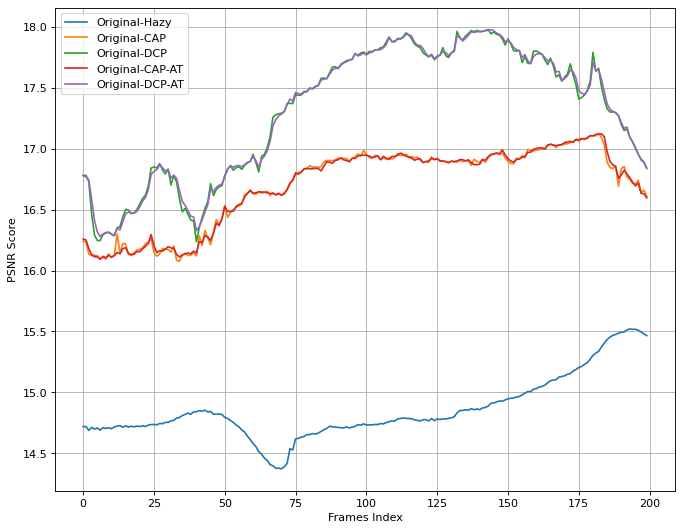

In [32]:
scores_1 = skvideo.measure.psnr(ref_vid_gray, haz_vid_gray)
scores_2 = skvideo.measure.psnr(ref_vid_gray, dis_cap_vid_gray)
scores_3 = skvideo.measure.psnr(ref_vid_gray, dis_dcp_vid_gray)
scores_4 = skvideo.measure.psnr(ref_vid_gray, dis_cap_atm_vid_gray)
scores_5 = skvideo.measure.psnr(ref_vid_gray, dis_dcp_atm_vid_gray)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_1)),scores_1)
plt.plot(range(len(scores_2)),scores_2)
plt.plot(range(len(scores_3)),scores_3)
plt.plot(range(len(scores_4)),scores_4)
plt.plot(range(len(scores_5)),scores_5)

plt.legend(['Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper left')
plt.xlabel('Frames Index')
plt.ylabel('PSNR Score')
plt.grid()
# plt.savefig('../result/vqs_psnr.png')
plt.show()

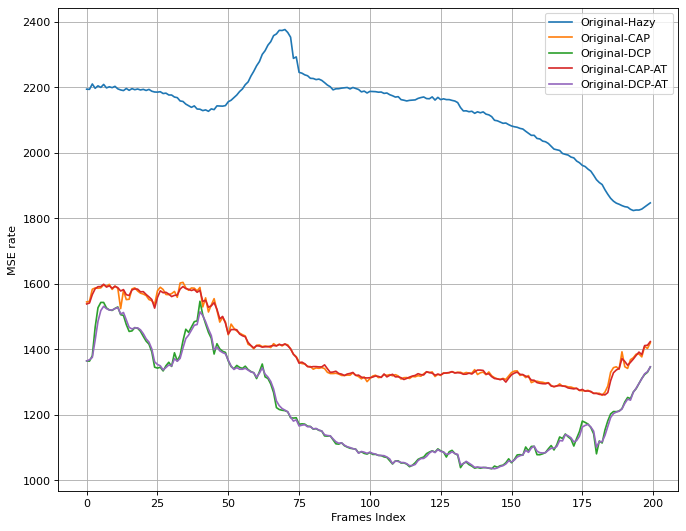

In [33]:
scores_1 = skvideo.measure.mse(ref_vid_gray, haz_vid_gray)
scores_2 = skvideo.measure.mse(ref_vid_gray, dis_cap_vid_gray)
scores_3 = skvideo.measure.mse(ref_vid_gray, dis_dcp_vid_gray)
scores_4 = skvideo.measure.mse(ref_vid_gray, dis_cap_atm_vid_gray)
scores_5 = skvideo.measure.mse(ref_vid_gray, dis_dcp_atm_vid_gray)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_1)),scores_1)
plt.plot(range(len(scores_2)),scores_2)
plt.plot(range(len(scores_3)),scores_3)
plt.plot(range(len(scores_4)),scores_4)
plt.plot(range(len(scores_5)),scores_5)

plt.legend(['Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper right')
plt.xlabel('Frames Index')
plt.ylabel('MSE rate')
plt.grid()
# plt.savefig('../result/vqs_mse.png')
plt.show()

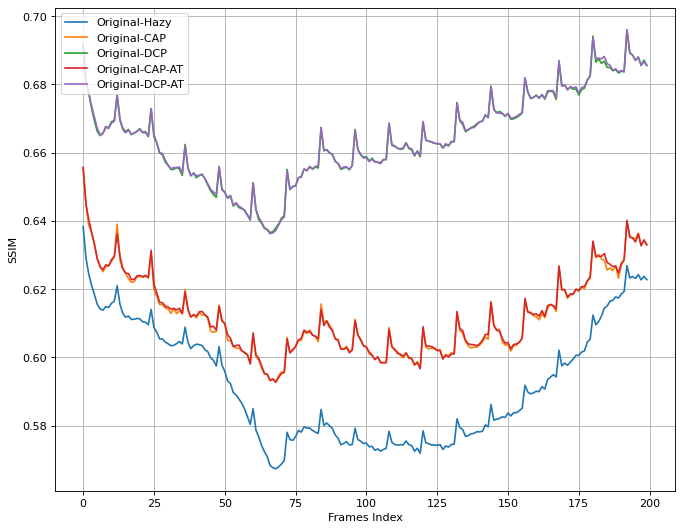

In [36]:
ref_vid_y = convert_luminance(ref_vid)
haz_vid_y = convert_luminance(haz_vid)
dis_cap_vid_y = convert_luminance(dis_cap_vid)
dis_dcp_vid_y = convert_luminance(dis_dcp_vid)
dis_cap_atm_vid_y = convert_luminance(dis_cap_atm_vid)
dis_dcp_atm_vid_y = convert_luminance(dis_dcp_atm_vid)

scores_1 = ssim(ref_vid_y, haz_vid_y)
scores_2 = ssim(ref_vid_y, dis_cap_vid_y)
scores_3 = ssim(ref_vid_y, dis_dcp_vid_y)
scores_4 = ssim(ref_vid_y, dis_cap_atm_vid_y)
scores_5 = ssim(ref_vid_y, dis_dcp_atm_vid_y)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_1)),scores_1)
plt.plot(range(len(scores_2)),scores_2)
plt.plot(range(len(scores_3)),scores_3)
plt.plot(range(len(scores_4)),scores_4)
plt.plot(range(len(scores_5)),scores_5)

plt.legend(['Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper left')
plt.xlabel('Frames Index')
plt.ylabel('SSIM')
plt.grid()
# plt.savefig('../result/vqs_ssim.png')
plt.show()

In [37]:
scores_0 = skvideo.measure.strred(ref_vid_gray, ref_vid_gray)
scores_1 = skvideo.measure.strred(ref_vid_gray, haz_vid_gray)
scores_2 = skvideo.measure.strred(ref_vid_gray, dis_cap_vid_gray)
scores_3 = skvideo.measure.strred(ref_vid_gray, dis_dcp_vid_gray)
scores_4 = skvideo.measure.strred(ref_vid_gray, dis_cap_atm_vid_gray)
scores_5 = skvideo.measure.strred(ref_vid_gray, dis_dcp_atm_vid_gray)

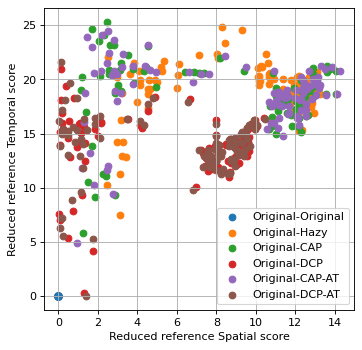

In [38]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(scores_0[0][:,2],scores_0[0][:,3])
plt.scatter(scores_1[0][:,2],scores_1[0][:,3])
plt.scatter(scores_2[0][:,2],scores_2[0][:,3])
plt.scatter(scores_3[0][:,2],scores_3[0][:,3])
plt.scatter(scores_4[0][:,2],scores_4[0][:,3])
plt.scatter(scores_5[0][:,2],scores_5[0][:,3])

plt.legend(['Original-Original', 'Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='lower right')
plt.xlabel('Reduced reference Spatial score')
plt.ylabel('Reduced reference Temporal score')
plt.grid()
# plt.savefig('../result/vqs_strred.png')
plt.show()

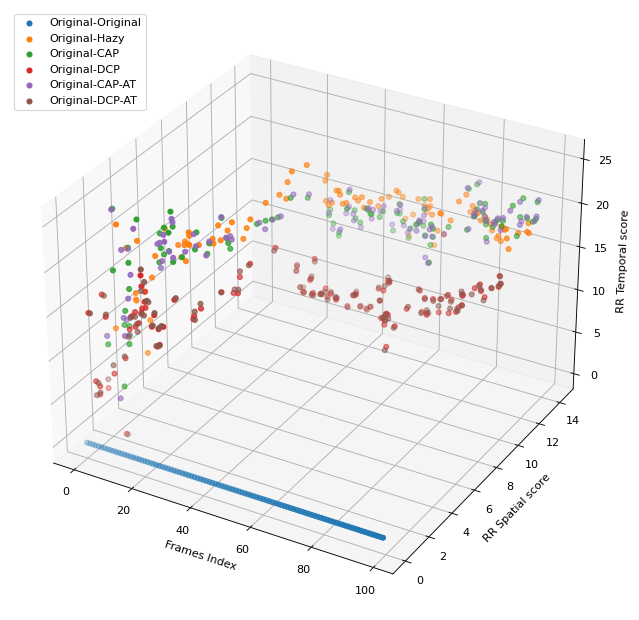

In [39]:
# plt.figure(figsize=(5, 5), dpi=80)
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(range(len(scores_0[0][:,3])), scores_0[0][:,2],scores_0[0][:,3])
ax.scatter(range(len(scores_1[0][:,3])), scores_1[0][:,2],scores_1[0][:,3])
ax.scatter(range(len(scores_2[0][:,3])), scores_2[0][:,2],scores_2[0][:,3])
ax.scatter(range(len(scores_3[0][:,3])), scores_3[0][:,2],scores_3[0][:,3])
ax.scatter(range(len(scores_4[0][:,3])), scores_4[0][:,2],scores_4[0][:,3])
ax.scatter(range(len(scores_5[0][:,3])), scores_5[0][:,2],scores_5[0][:,3])

ax.legend(['Original-Original', 'Original-Hazy','Original-CAP', 'Original-DCP', 'Original-CAP-AT', 'Original-DCP-AT'], loc='upper left')
ax.set_ylabel('RR Spatial score')
ax.set_zlabel('RR Temporal score')
ax.set_xlabel('Frames Index')
ax.grid()
# fig.savefig('../result/vqs_strred_3d.png')

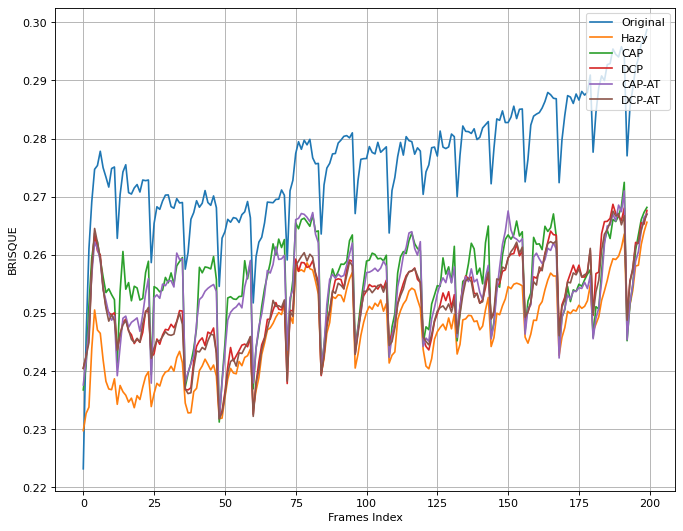

In [40]:
scores_0 = brisque_features(ref_vid_gray)
scores_1 = brisque_features(haz_vid_gray)
scores_2 = brisque_features(dis_cap_vid_gray)
scores_3 = brisque_features(dis_dcp_vid_gray)
scores_4 = brisque_features(dis_cap_atm_vid_gray)
scores_5 = brisque_features(dis_dcp_atm_vid_gray)
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(range(len(scores_0)),np.mean(scores_0, axis=1))
plt.plot(range(len(scores_1)),np.mean(scores_1, axis=1))
plt.plot(range(len(scores_2)),np.mean(scores_2, axis=1))
plt.plot(range(len(scores_3)),np.mean(scores_3, axis=1))
plt.plot(range(len(scores_4)),np.mean(scores_4, axis=1))
plt.plot(range(len(scores_5)),np.mean(scores_5, axis=1))

plt.legend(['Original', 'Hazy','CAP', 'DCP', 'CAP-AT', 'DCP-AT'], loc='upper right')
plt.xlabel('Frames Index')
plt.ylabel('BRISQUE')
plt.grid()
# plt.savefig('../result/vqs_brisque.png')
plt.show()